In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 1
from imports import *
from functions import *

# Get Available Stations ID List

In [3]:
# get all stations and some metadata as a Pandas DataFrame
stations_df = api.stations()
# parse the response as a dictionary
stations_df = api.stations(as_df=True)

print(len(stations_df))

146


# Filter Buoys by Remarks

In [4]:
access_error_url_list = []

# Liste de mots à rechercher dans la colonne "Remark"
blacklist = ["Failure", "ceased", "failed", "recovered", "stopped", 'adrift']
stations_id_set = set()

print(f'Avant Filtre: {stations_df.shape[0]}')

# Liste pour collecter les indices à supprimer
indices_a_supprimer = []

# Parcours des lignes de la DataFrame
for idx, row in stations_df.iterrows():
    station_id = row["Station"]
    station_Location = row["Hull No./Config and Location"]  # Extraire la valeur de la cellule pour chaque ligne
    
    # Extraction du nom de la station si un ")" est trouvé
    if ")" in station_Location:
        station_name = station_Location.split(')')[1].rstrip(" )")  # On enlève l'espace et la parenthèse en fin de chaîne
    else:
        station_name = station_Location.strip()  # Si pas de ")", on garde toute la chaîne

    station_name = station_name.rstrip(" )").replace("(", "").replace(")", "").strip()

    # Nettoyage final pour enlever toute parenthèse ou espace en fin de nom
    station_name = station_name.rstrip(" )")

    # Vérifier si "Remark" n'est pas NaN et si un des éléments de blacklist est dans "Remark"
    if isinstance(row["Remark"], str) and any(blacklist_word.lower() in row["Remark"].lower() for blacklist_word in blacklist):
        # Ajouter l'index à la liste
        indices_a_supprimer.append(idx)
        url = get_buoy_url(station_id)
        access_error_url_list.append(url)
    else:
        pass
# Supprimer les lignes après la boucle
stations_df.drop(index=indices_a_supprimer, inplace=True)

print(f'Après Filtre: {stations_df.shape[0]}')

Avant Filtre: 146
Après Filtre: 45


# Build Buoys_datas Dict

In [5]:
# Dictionnaire pour stocker les DataFrames, clé : ID de la bouée, valeur : DataFrame
buoy_datas = {}
buoy_list = []

# Parcours de chaque bouée dans stations_df
for index, row in stations_df.iterrows():
    buoy_id = row['Station']
    metadata = get_station_metadata(buoy_id)

    # ✅ Récupérer les données sous forme de dictionnaire
    buoy_info = parse_buoy_json(metadata)

    # ✅ Stocker directement les données dans buoy_datas
    buoy_datas[buoy_id] = buoy_info
    buoy_list.append(buoy_id)

# Affichage du nombre de bouées réussies et échouées
print(f"Nombre de bouées traitées : {len(buoy_datas)}\n")

# Afficher le contenu de buoy_datas

first_key =next(iter(buoy_datas))
first_key
buoy_datas[first_key]


🔍 Début du parsing de la bouée...
🌍 Zone de la station : grays reef
🆔 Station ID : 41008
✅ Coordonnées extraites : Latitude = 31.40N, Longitude = 80.87W
🌊 Water Depth : 16 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41008
✅ Parsing terminé !


🔍 Début du parsing de la bouée...
🌍 Zone de la station : ne st martin
🆔 Station ID : 41044
✅ Coordonnées extraites : Latitude = 21.58N, Longitude = 58.63W
🌊 Water Depth : 5419 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41044
✅ Parsing terminé !


🔍 Début du parsing de la bouée...
🌍 Zone de la station : south bermuda
🆔 Station ID : 41049
✅ Coordonnées extraites : Latitude = 27.50N, Longitude = 62.27W
🌊 Water Depth : 5480 m
🌡️ Sea Temp Depth : 1.5
🌬️ Barometer Elevation (m): 2.7
💨 An

{'station_zone': 'grays reef',
 'lat_buoy': '31.40N',
 'lon_buoy': '80.87W',
 'Water_depth': '16 m',
 'sea_temp_depth': '2',
 'Barometer_elevation': '2.4',
 'Anemometer_height': '3.8',
 'Air_temp_height': '3.4',
 'url': 'https://www.ndbc.noaa.gov/station_page.php?station=41008'}

# Collecte de données marines et météos

In [6]:
# 🚀 Démarrage du processus
print("\n🚀 Démarrage du processus de collecte des données...\n")

# Initialisation des compteurs
marine_data_collected_successfully = marine_data_collected_failed = 0
meteo_data_collected_successfully = meteo_data_collected_failed = 0

success = False
total_stations = stations_df.shape[0]
count = 0

# 🔄 Parcours des bouées / stations
for idx, row in stations_df.iterrows():
    buoy_id = row["Station"]

    ######### 🌊 MARINE DATA #########
    try:
        df_marine = NDBC.realtime_observations(buoy_id)
        if df_marine is None or df_marine.empty:
            marine_data_collected_failed += 1
            continue

        marine_data_collected_successfully += 1
    except Exception as e:
        print(f"⚠️ Erreur collecte marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    # Ajout des métadonnées
    try:
        buoy_info = buoy_datas.get(buoy_id, {})
        Lat, Lon = buoy_info.get('lat_buoy'), buoy_info.get('lon_buoy')
        if Lat is None or Lon is None:
            raise ValueError(f"Données manquantes pour {buoy_id}")

        df_marine['Lat'] = Lat
        df_marine['Lon'] = Lon
        df_marine['Water_depth'] = buoy_info.get('Water_depth', None)
        df_marine.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_marine.columns]
        df_marine['Datetime'] = df_marine['Datetime'].dt.tz_localize(None)

        buoy_datas[buoy_id]["Marine"] = df_marine

        station_zone = safe_get(parse_buoy_json(get_station_metadata(buoy_id)), "station_zone")
        Bronze_Marine_table_Name = f"br_{buoy_id}_marine_{station_zone}".replace('.', '_').replace('-', '_').replace(' ', '_').lower()

    except Exception as e:
        print(f"⚠️ Erreur métadonnées marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    ######### ⛅ METEO DATA #########
    try:
        df_meteo = meteo_api_request([Lat, Lon])
        if df_meteo is None or df_meteo.empty:
            meteo_data_collected_failed += 1
            continue
        
        rename_columns(df_meteo, {'date':'Datetime'})
        df_meteo.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_meteo.columns]
        df_meteo['Datetime'] = df_meteo['Datetime'].dt.tz_localize(None)
    
        buoy_datas[buoy_id]["Meteo"] = df_meteo
        meteo_data_collected_successfully += 1
    except Exception as e:
        print(f"⚠️ Erreur collecte météo {buoy_id}: {e}")
        meteo_data_collected_failed += 1
        continue

# Retirer les bouées avec des DataFrames vides ou None
buoy_datas = {buoy_id: data for buoy_id, data in buoy_datas.items() 
              if "Marine" in data and data["Marine"] is not None and not data["Marine"].empty
              and "Meteo" in data and data["Meteo"] is not None and not data["Meteo"].empty}

# 🔚 Résumé final

print("\n📝 Résumé final :")
print(f"🌊 Marine - Collecte ✅ {marine_data_collected_successfully} ❌ {marine_data_collected_failed}")
print(f"⛅ Météo - Collecte ✅ {meteo_data_collected_successfully} ❌ {meteo_data_collected_failed}")

# Afficher la longueur du dictionnaire (nombre de bouées avec des données valides)
print(f"\n📊 Nombre de bouées avec des données valides : {len(buoy_datas)}")


🚀 Démarrage du processus de collecte des données...


🔍 Début du parsing de la bouée...
🌍 Zone de la station : grays reef
🆔 Station ID : 41008
✅ Coordonnées extraites : Latitude = 31.40N, Longitude = 80.87W
🌊 Water Depth : 16 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41008
✅ Parsing terminé !

📊 station_zone : grays reef
🔄 Colonne 'date' renommée en 'Datetime'
✅ Colonnes renommées : {'date': 'Datetime'}

🔍 Début du parsing de la bouée...
🌍 Zone de la station : ne st martin
🆔 Station ID : 41044
✅ Coordonnées extraites : Latitude = 21.58N, Longitude = 58.63W
🌊 Water Depth : 5419 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41044
✅ Parsing terminé !

📊 station_zone : ne st martin
🔄 Colonne 'date' renommée en 'Datetime'
✅ Co

# Data Enrichment with MetaDatas

In [7]:
list_not_include = ['lon_buoy', "lat_buoy", "url"]
for buoy_id, value in buoy_datas.items():
    print(f"\n🔍 Traitement de la Station ID: {buoy_id}")

    marine_df = buoy_datas[buoy_id]["Marine"]
    meteo_df = buoy_datas[buoy_id]["Meteo"]

    try:
        # Récupérer les métadonnées de la station
        buoy_metadata = get_station_metadata(buoy_id)
        parsed_data = parse_buoy_json(buoy_metadata)

        # Mise à jour du dictionnaire avec les métadonnées
        data = buoy_datas[buoy_id]
        data.update(parsed_data)
        
        # Ajouter les métadonnées comme nouvelles colonnes dans marine_df
        if marine_df is not None:
            marine_df["Station ID"] = str(buoy_id)
            for key, value in parsed_data.items():
                # Vérifier si la clé n'est pas dans la liste des exclusions
                if key not in list_not_include:
                    marine_df[key] = value
                    print(f"✅ Colonne '{key}' ajoutée au DataFrame de la station {buoy_id}")

    except Exception as e:
        print(f"❌ Erreur pour la station {buoy_id}: {e}")

# Vérification de l'ajout des colonnes en prenant un id au hasard
station_id = random.choice(list(buoy_datas.keys()))
marine_df = buoy_datas[station_id]["Marine"]

if marine_df is not None:
    print("\nColonnes ajoutées au DataFrame de la station", station_id)
    print(marine_df.columns)


🔍 Traitement de la Station ID: 41008

🔍 Début du parsing de la bouée...
🌍 Zone de la station : grays reef
🆔 Station ID : 41008
✅ Coordonnées extraites : Latitude = 31.40N, Longitude = 80.87W
🌊 Water Depth : 16 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41008
✅ Parsing terminé !

✅ Colonne 'station_zone' ajoutée au DataFrame de la station 41008
✅ Colonne 'Water_depth' ajoutée au DataFrame de la station 41008
✅ Colonne 'sea_temp_depth' ajoutée au DataFrame de la station 41008
✅ Colonne 'Barometer_elevation' ajoutée au DataFrame de la station 41008
✅ Colonne 'Anemometer_height' ajoutée au DataFrame de la station 41008
✅ Colonne 'Air_temp_height' ajoutée au DataFrame de la station 41008

🔍 Traitement de la Station ID: 41044

🔍 Début du parsing de la bouée...
🌍 Zone de la station : ne st martin
🆔 Station ID : 41044
✅ Coordonnées extraites : Latitude = 21.58

In [8]:
display_buoys_missing_df_counts(buoy_datas)


🌊 Nombre de bouées sans données 'Marine' : 0/43

☁️ Nombre de bouées sans données 'Meteo' : 0/43


In [9]:
display(df_marine.columns)
display(df_meteo.columns)

Index(['wind_direction', 'wind_speed', 'wind_gust', 'wave_height',
       'dominant_wave_period', 'average_wave_period',
       'dominant_wave_direction', 'pressure', 'air_temperature',
       'water_temperature', 'dewpoint', 'visibility', '3hr_pressure_tendency',
       'water_level_above_mean', 'Datetime', 'Lat', 'Lon', 'Water_depth',
       'Station ID', 'station_zone', 'sea_temp_depth', 'Barometer_elevation',
       'Anemometer_height', 'Air_temp_height'],
      dtype='object')

Index(['Datetime', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

# Handle Null Values

In [10]:
important_columns_oceanography = [
    'wind_direction',             
    'wind_speed',                 
    'wave_height',                   
    'pressure',                   
    'air_temperature',            
    'water_temperature',          
    'Datetime',
    'Lat',
    'Lon'                 
]

important_columns_meteorology = [
    'temperature_2m',             
    'relative_humidity_2m',       
    'dew_point_2m',               
    'precipitation',              
    'pressure_msl',               
    'cloud_cover',                
    'wind_speed_10m',             
    'Datetime'
]

stations_depart = len(buoy_datas)
ignored_buoys = {}  # Dictionary to track ignored buoys and their reasons

for station_id, data in buoy_datas.items():
    print(f"\n🔄 Nettoyage des données pour la station {station_id}")

    marine_df = data.get("Marine")
    meteo_df = data.get("Meteo")

    if marine_df is None or meteo_df is None:
        ignored_buoys[station_id] = "Marine DataFrame ou Meteo DataFrame manquant(e)"
        print(f"⚠️ Station {station_id} ignorée: Marine DataFrame ou Meteo DataFrame manquant(e)")
        continue

    try:
        # Nettoyage des DataFrames
        cleaned_marine_df = handle_null_values(marine_df)
        cleaned_meteo_df = handle_null_values(meteo_df)
        # Vérification des colonnes importantes après nettoyage
        marine_columns_ok = all(col in cleaned_marine_df.columns for col in important_columns_oceanography)
        meteo_columns_ok = all(col in cleaned_meteo_df.columns for col in important_columns_meteorology)

        # Track which columns are missing
        missing_marine_columns = [col for col in important_columns_oceanography if col not in cleaned_marine_df.columns]
        missing_meteo_columns = [col for col in important_columns_meteorology if col not in cleaned_meteo_df.columns]

        if missing_marine_columns or missing_meteo_columns:
            ignored_buoys[station_id] = f"Colonnes manquantes: Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}"
            print(f"⚠️ Station {station_id} ignorée: Colonnes manquantes - Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}")
            continue

        # Ajouter le DataFrame nettoyé au dictionnaire des résultats
        buoy_datas[station_id]['Cleaned Marine'] = cleaned_marine_df
        buoy_datas[station_id]['Cleaned Meteo'] = cleaned_meteo_df
        print(f"✅ Nettoyage réussi pour la station {station_id} ({cleaned_marine_df.shape[0]} lignes)")

    except Exception as e:
        ignored_buoys[station_id] = f"Erreur lors du nettoyage: {e}"
        print(f"❌ Erreur lors du nettoyage pour {station_id}: {e}")

# 🔥 Suppression des stations ignorées du dictionnaire principal
for station_id in ignored_buoys:
    buoy_datas.pop(station_id, None)

len_cleaned_data = len([data for data in buoy_datas.values() if 'Cleaned Marine' in data and 'Cleaned Meteo' in data])

# Résumé final du nettoyage
print("\n📊 RÉSUMÉ DU NETTOYAGE:")
print(f"📌 Stations au départ : {stations_depart}")
print(f"✅ Stations nettoyées : {len_cleaned_data}")
print(f"🏁 Stations restantes après filtrage :")

for station_id, reason in ignored_buoys.items():
    print(f"🛑 Station {station_id} ignorée: {reason}")

print(f"\n🧹 Clés restantes dans buoy_datas après purge : {len(buoy_datas)} (attendu : {len_cleaned_data})")


🔄 Nettoyage des données pour la station 41008

Tag: orange - Nombre de lignes: 6494
Colonne 'wind_direction' Imputée par la médiane (19.08% de valeurs manquantes)
Colonne 'wind_speed' Imputée par la médiane (18.85% de valeurs manquantes)
Colonne 'wind_gust' Imputée par la médiane (18.85% de valeurs manquantes)
Colonne 'wave_height' Imputée par la médiane (49.29% de valeurs manquantes)
Colonne 'dominant_wave_period' Supprimée (plus de 55% de valeurs manquantes)
Colonne 'average_wave_period' Imputée par la médiane (49.31% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imputée par la médiane (49.34% de valeurs manquantes)
Colonne 'pressure' Imputée par la médiane (0.17% de valeurs manquantes)
Colonne 'air_temperature' Imputée par la médiane (18.85% de valeurs manquantes)
Colonne 'water_temperature' Imputée par la médiane (14.12% de valeurs manquantes)
Colonne 'dewpoint' Imputée par la médiane (19.2% de valeurs manquantes)
Colonne 'visibility' Supprimée (plus de 55% de valeurs m

In [11]:
display_buoys_missing_df_counts(buoy_datas, prefix="Cleaned")


🌊 Nombre de bouées sans données 'Cleaned Marine' : 0/25

☁️ Nombre de bouées sans données 'Cleaned Meteo' : 0/25


In [12]:
display_row_values(df_meteo)

Datetime             |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2025-01-13 00:00:00  |  1.635           |  73.0                  |  -2.52         |  0.0            |  0.0   |  0.0      |  1015.4        |  990.58496         |  87.0         |  21.0             |  0.0              |  0.0               |  23400.0     |  18.14           |  3.89                  |  0.31                    |  0.0   
2025-01-13 01:00:00  

# Fusionner les df_meteo et df_marine sur 'Datetime'

In [13]:
# Fusion des DataFrames nettoyés
print("\n🔗 FUSION DES DONNÉES MARINE + METEO PAR STATION")

merged_success_count = 0  # Compteur de fusions réussies
total_merged_rows = 0     # Total de lignes fusionnées

for station_id, data in buoy_datas.items():
    print(f"\n🔄 Fusion des données pour la station {station_id}")

    cleaned_marine_df = data.get("Cleaned Marine")
    cleaned_meteo_df = data.get("Cleaned Meteo")

    if cleaned_marine_df is None or cleaned_meteo_df is None:
        continue

    try:
        merged_df = pd.merge(cleaned_marine_df, cleaned_meteo_df, on="Datetime", how="inner")

        if merged_df.empty:
            print(f"⚠️ Station {station_id} fusionnée, mais résultat vide après inner merge sur 'Datetime'")
        else:
            buoy_datas[station_id]["Merged"] = merged_df
            merged_success_count += 1
            total_merged_rows += len(merged_df)
            print(f"✅ Fusion réussie pour la station {station_id} ({merged_df.shape[0]} lignes)")

    except Exception as e:
        print(f"❌ Erreur lors de la fusion pour {station_id}: {e}")

# Résumé des fusions
print(f"\n📦 Fusions réussies : {merged_success_count}/{len_cleaned_data} stations")
print(f"📊 Total de lignes fusionnées : {total_merged_rows}")


🔗 FUSION DES DONNÉES MARINE + METEO PAR STATION

🔄 Fusion des données pour la station 41008
✅ Fusion réussie pour la station 41008 (1089 lignes)

🔄 Fusion des données pour la station 41044
✅ Fusion réussie pour la station 41044 (1081 lignes)

🔄 Fusion des données pour la station 41049
✅ Fusion réussie pour la station 41049 (1089 lignes)

🔄 Fusion des données pour la station 42001
✅ Fusion réussie pour la station 42001 (796 lignes)

🔄 Fusion des données pour la station 42002
✅ Fusion réussie pour la station 42002 (820 lignes)

🔄 Fusion des données pour la station 42020
✅ Fusion réussie pour la station 42020 (1089 lignes)

🔄 Fusion des données pour la station 42036


✅ Fusion réussie pour la station 42036 (1080 lignes)

🔄 Fusion des données pour la station 42056
✅ Fusion réussie pour la station 42056 (1089 lignes)

🔄 Fusion des données pour la station 42058
✅ Fusion réussie pour la station 42058 (1086 lignes)

🔄 Fusion des données pour la station 44007
✅ Fusion réussie pour la station 44007 (1088 lignes)

🔄 Fusion des données pour la station 44020
✅ Fusion réussie pour la station 44020 (1088 lignes)

🔄 Fusion des données pour la station 44065
✅ Fusion réussie pour la station 44065 (1090 lignes)

🔄 Fusion des données pour la station 46006
✅ Fusion réussie pour la station 46006 (1086 lignes)

🔄 Fusion des données pour la station 46014
✅ Fusion réussie pour la station 46014 (1089 lignes)

🔄 Fusion des données pour la station 46025
✅ Fusion réussie pour la station 46025 (1088 lignes)

🔄 Fusion des données pour la station 46027
✅ Fusion réussie pour la station 46027 (1087 lignes)

🔄 Fusion des données pour la station 46072
✅ Fusion réussie pour la stati

# Concaténation des DataFrames fusionnés

In [14]:
# Concaténation des DataFrames fusionnés
print("\n🧬 CONCATÉNATION DES DONNÉES FUSIONNÉES EN UN SEUL DATAFRAME")

final_merged_df_list = []
concat_success_count = 0
concat_total_rows = 0

for station_id, data in buoy_datas.items():
    merged_df = data.get("Merged")

    if merged_df is None:
        print(f"⚠️ Station {station_id} ignorée pour concaténation: Données fusionnées manquantes")
        continue

    try:
        final_merged_df_list.append(merged_df)
        concat_success_count += 1
        concat_total_rows += len(merged_df)
        print(f"✅ Concaténation réussie pour la station {station_id} ({len(merged_df)} lignes)")

    except Exception as e:
        print(f"❌ Erreur lors de la concaténation pour {station_id}: {e}")

# Création du DataFrame final unique
try:
    df_final = pd.concat(final_merged_df_list, ignore_index=True)
    print(f"\n🧾 DataFrame final créé avec succès ({df_final.shape[0]} lignes, {df_final.shape[1]} colonnes)")
except Exception as e:
    print(f"\n❌ Erreur lors de la création du DataFrame final: {e}")
    df_final = None

# Résumé
print(f"\n📦 Concaténations réussies : {concat_success_count}/{merged_success_count}")
print(f"📊 Total de lignes dans le DataFrame final : {concat_total_rows}")


🧬 CONCATÉNATION DES DONNÉES FUSIONNÉES EN UN SEUL DATAFRAME
✅ Concaténation réussie pour la station 41008 (1089 lignes)
✅ Concaténation réussie pour la station 41044 (1081 lignes)
✅ Concaténation réussie pour la station 41049 (1089 lignes)
✅ Concaténation réussie pour la station 42001 (796 lignes)
✅ Concaténation réussie pour la station 42002 (820 lignes)
✅ Concaténation réussie pour la station 42020 (1089 lignes)
✅ Concaténation réussie pour la station 42036 (1080 lignes)
✅ Concaténation réussie pour la station 42056 (1089 lignes)
✅ Concaténation réussie pour la station 42058 (1086 lignes)
✅ Concaténation réussie pour la station 44007 (1088 lignes)
✅ Concaténation réussie pour la station 44020 (1088 lignes)
✅ Concaténation réussie pour la station 44065 (1090 lignes)
✅ Concaténation réussie pour la station 46006 (1086 lignes)
✅ Concaténation réussie pour la station 46014 (1089 lignes)
✅ Concaténation réussie pour la station 46025 (1088 lignes)
✅ Concaténation réussie pour la station 4

In [15]:
display_row_values(df_final)

wind_direction  |  wind_speed  |  wind_gust  |  wave_height  |  average_wave_period  |  dominant_wave_direction  |  pressure  |  air_temperature  |  water_temperature  |  dewpoint  |  Datetime             |  Lat     |  Lon      |  Water_depth  |  Station ID  |  station_zone                              |  sea_temp_depth  |  Barometer_elevation  |  Anemometer_height  |  Air_temp_height  |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Hour Filtering

In [16]:
try:
    df_final['Datetime'] = pd.to_datetime(df_final['Datetime'])

    df_final = df_final[df_final['Datetime'].dt.minute == 0]
    # Affichage pour vérifier le résultat
    print(f"🚀 DataFrame filtrée pour ne garder que les lignes à l'heure pile: {df_final.shape[0]} lignes")

except Exception as e:
    print(f"�� Erreur lors du filtrage des lignes à l'heure pile: {e}")

🚀 DataFrame filtrée pour ne garder que les lignes à l'heure pile: 26631 lignes


In [17]:
final_datetime = pd.DataFrame(df_final[['Datetime']], dtype='datetime64[ns]')
final_datetime

,Datetime
0,2025-04-15 09:00:00
1,2025-04-15 08:00:00
2,2025-04-15 07:00:00
3,2025-04-15 06:00:00
4,2025-04-15 05:00:00
...,...
26626,2025-03-01 04:00:00
26627,2025-03-01 03:00:00
26628,2025-03-01 02:00:00
26629,2025-03-01 01:00:00


In [18]:
df_final = handle_null_values(df_final)
display_row_values(df_final)


Tag: yellow - Nombre de lignes: 26631
Colonne 'wind_direction' non modifiée (0% de valeurs manquantes)
Colonne 'wind_speed' non modifiée (0% de valeurs manquantes)
Colonne 'wind_gust' non modifiée (0% de valeurs manquantes)
Colonne 'wave_height' non modifiée (0% de valeurs manquantes)
Colonne 'average_wave_period' non modifiée (0% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imputée par la médiane (4.09% de valeurs manquantes)
Colonne 'pressure' non modifiée (0% de valeurs manquantes)
Colonne 'air_temperature' non modifiée (0% de valeurs manquantes)
Colonne 'water_temperature' non modifiée (0% de valeurs manquantes)
Colonne 'dewpoint' non modifiée (0% de valeurs manquantes)
Colonne 'Datetime' non modifiée (0% de valeurs manquantes)
Colonne 'Lat' non modifiée (0% de valeurs manquantes)
Colonne 'Lon' non modifiée (0% de valeurs manquantes)
Colonne 'Water_depth' non modifiée (0% de valeurs manquantes)
Colonne 'Station ID' non modifiée (0% de valeurs manquantes)
Colonne 'stati

In [19]:
# get station id distinct values
station_ids = df_final['Station ID'].unique()
print(station_ids)

['41008' '41044' '41049' '42001' '42002' '42020' '42036' '42056' '42058'
 '44007' '44020' '44065' '46006' '46014' '46025' '46027' '46072' '46078'
 '46084' '46086' '46087' '46088' '51000' '51001' '51002']


In [20]:
df_final.columns = [col.strip() for col in df_final.columns]

# Renaming and deleting useless columns

In [21]:
# Dictionnaire de renommage des colonnes
col_to_rename = {'temperature_2m': 'T°(C°)', 
                 'relative_humidity_2m': 'Relative Humidity (%)',
                 'dew_point_2m': 'Dew Point (°C)', 
                 'precipitation': 'Precipitations (mm)',  
                 'pressure_msl':'Sea Level Pressure (hPa)', 
                 'cloud_cover_low':'Low Clouds (%)',
                 'cloud_cover_mid' : 'Middle Clouds (%)', 
                 'cloud_cover_high' : 'High Clouds (%)', 
                 'visibility' : 'Visibility (km)', 
                 'wind_direction': 'Wind Direction (°)',
                 'wind_speed': 'Wind Speed (km/h)', 
                 'wind_gust': 'Wind Gusts (km/h)',
                 'wind_speed_10m':'Wind Speed (10m)', 
                 'surface_pressure': 'Surface Pressure',
                 'wave_height': 'Wave Height (m)', 
                 'average_wave_period': 'Average Wave Period (s)',
                 'dominant_wave_direction': 'Dominant Wave Direction (°)', 
                 'pressure': 'Pressure (hPa)',
                 'air_temperature': 'Air T°', 
                 'water_temperature': 'Water T°', 
                 'Water_depth': 'Water Depth (m)', 
                 "Air_temp_height": "Air T° Height", 
                 "Anemometer_height": "Anemometer Height (m)", 
                 "station_zone": "Station Zone",
                 "Barometer_elevation": "Barometer Elevation", 
                 "sea_temp_depth" : "Sea Temperature Depth (m)"}


# Liste des colonnes à supprimer
cols_to_delete = ['soil_temperature_0cm', 'lat_buoy','lon_buoy', 'rain', 
                  'showers', 'is_day', 'soil_moisture_0_to_1cm', 
                  'cloud_cover']
	
# Renommer les colonnes d'abord
df_final = rename_columns(df_final, col_to_rename)
# Ensuite, supprimer les colonnes non désirées
df_final = drop_columns_if_exist(df_final, cols_to_delete)
try:
    if df_final['Visibility (km)'].mean() > 1000:
        df_final['Visibility (km)'] = df_final['Visibility (km)'] / 1000
        print("Conversion de la visibilité de mètres à kilomètres")
    df_final["T°(C°)"] = round(df_final["T°(C°)"], 2)
    df_final["Wind Speed (10m)"] = round(df_final["Wind Speed (10m)"], 2)
except Exception as e:
    print(f"�� Erreur lors du traitement des colonnes :\n {e}")

# Afficher les résultats
print("\nColonnes après renommage et suppression :")
display_row_values(df_final)

🔄 Colonne 'temperature_2m' renommée en 'T°(C°)'
🔄 Colonne 'relative_humidity_2m' renommée en 'Relative Humidity (%)'
🔄 Colonne 'dew_point_2m' renommée en 'Dew Point (°C)'
🔄 Colonne 'precipitation' renommée en 'Precipitations (mm)'
🔄 Colonne 'pressure_msl' renommée en 'Sea Level Pressure (hPa)'
🔄 Colonne 'cloud_cover_low' renommée en 'Low Clouds (%)'
🔄 Colonne 'cloud_cover_mid' renommée en 'Middle Clouds (%)'
🔄 Colonne 'cloud_cover_high' renommée en 'High Clouds (%)'
🔄 Colonne 'visibility' renommée en 'Visibility (km)'
🔄 Colonne 'wind_direction' renommée en 'Wind Direction (°)'
🔄 Colonne 'wind_speed' renommée en 'Wind Speed (km/h)'
🔄 Colonne 'wind_gust' renommée en 'Wind Gusts (km/h)'
🔄 Colonne 'wind_speed_10m' renommée en 'Wind Speed (10m)'
🔄 Colonne 'surface_pressure' renommée en 'Surface Pressure'
🔄 Colonne 'wave_height' renommée en 'Wave Height (m)'
🔄 Colonne 'average_wave_period' renommée en 'Average Wave Period (s)'
🔄 Colonne 'dominant_wave_direction' renommée en 'Dominant Wave Di

In [22]:
try:
    display_row_values(df_final, columns=["Visibility (km)", "T°(C°)"])
#    df_final["Visibility (km)"] = df_final["Visibility (km)"].map(lambda x: x / 1000)
    
    df_final["T°(C°)"] = df_final["T°(C°)"].round(2)
    df_final[['Lat', 'Lon']] = df_final.apply(
        lambda row: pd.Series(convert_coordinates(row['Lat'], row['Lon'])),
        axis=1
    )
except Exception as e:
    print(f"Erreur : {e}")
display_row_values(df_final)

Visibility (km)  |  T°(C°)
-------------------------
18.5             |  18.8  
21.8             |  19.35 
26.1             |  19.6  
24.5             |  20.05 
19.8             |  20.2  
14.6             |  20.05 
15.1             |  20.05 
16.9             |  20.05 
17.2             |  20.25 
19.3             |  20.3  
Wind Direction (°)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Pressure (hPa)  |  Air T°  |  Water T°  |  dewpoint  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Surface Pressure  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
----------------------

In [23]:
#  T°(C°) = (Air T° + T°(C°))/2 et virer Air T°
try:
    df_final['T°(C°)'] = (df_final['Air T°'] + df_final['T°(C°)']) / 2
    df_final['T°(C°)'] = df_final['T°(C°)'].round(2)
    df_final.drop(columns=['Air T°'], inplace=True)
    df_final['Sea Level Pressure (hPa)'] = round((df_final['Sea Level Pressure (hPa)'] + df_final['Surface Pressure']) / 2, 2)
    df_final.drop(columns=['Surface Pressure'], inplace=True)
    df_final['Year'] = df_final['Datetime'].dt.year
    df_final['Month'] = df_final['Datetime'].dt.month_name()
    df_final['DayOfWeek'] = df_final['Datetime'].dt.day_name()
    df_final['DayPeriod'] = df_final['Datetime'].apply(
    lambda x: 'Morning' if 6 <= x.hour < 12 else
              'Afternoon' if 12 <= x.hour < 18 else
              'Evening' if 18 <= x.hour < 22 else
              'Night'
)
    df_final.drop(columns='Hour', inplace=True)
except Exception as e:
    print(f"Erreur :\n {e}")

# virer le m dans Water Depth avec regex lambda et passer la colonne en float
df_final['Water Depth (m)'] = df_final['Water Depth (m)'].apply(lambda x: re.sub(r'\D', '', str(x)).strip())
df_final['Water Depth (m)'] = df_final['Water Depth (m)'].astype(float)
display_row_values(df_final)

Erreur :
 "['Hour'] not found in axis"
Wind Direction (°)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Pressure (hPa)  |  Water T°  |  dewpoint  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Check truth about Wind Speed Using another API call

In [24]:
df_42058 = df_final[df_final['Station ID'] == "42058"]
df_42058.columns

Index(['Wind Direction (°)', 'Wind Speed (km/h)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Pressure (hPa)', 'Water T°', 'dewpoint',
       'Datetime', 'Lat', 'Lon', 'Water Depth (m)', 'Station ID',
       'Station Zone', 'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T° Height', 'T°(C°)',
       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Low Clouds (%)', 'Middle Clouds (%)',
       'High Clouds (%)', 'Visibility (km)', 'Wind Speed (10m)', 'Year',
       'Month', 'DayOfWeek', 'DayPeriod'],
      dtype='object')

# Requête à l'API Visual Crossing pour les données de vérification (1 / 24h)

In [25]:
# ---- Chargement de la clé API ----
vc_api_key_path = r"c:\Credentials\visual_crossing_weather_api.json"
with open(vc_api_key_path, 'r') as file:
    content = json.load(file)
    vc_api_key = content["api_key"]

# ---- Extraire les coordonnées depuis la première ligne du DataFrame ----
lat_42058, lon_42058 = None, None

if not df_42058.empty:
    first_row = df_42058.iloc[0]
    lat_42058, lon_42058 = first_row["Lat"], first_row["Lon"]

# ---- Définir les dates pour la requête ----
today = datetime.now().strftime("%Y-%m-%d")
last_month = (datetime.now() - timedelta(days=31)).strftime("%Y-%m-%d")

# ---- Créer le dossier de cache si nécessaire ----
cache_dir = "api_call_files"
os.makedirs(cache_dir, exist_ok=True)

# ---- Définir le fichier cache selon la position ----
cache_file = os.path.join(cache_dir, f"vc_meteo_{lat_42058}_{lon_42058}.csv")

# ---- Vérifier si un cache récent existe (moins de 24h) ----
use_cache = False
if os.path.exists(cache_file):
    last_modified = datetime.fromtimestamp(os.path.getmtime(cache_file))
    if datetime.now() - last_modified < timedelta(hours=24):
        print(f"📦 Cache détecté ({cache_file}), modifié le {last_modified.strftime('%Y-%m-%d %H:%M:%S')}")
        vc_meteo_df = pd.read_csv(cache_file)
        print("✅ Données météo rechargées depuis le cache.")
        use_cache = True
    else:
        print(f"⚠️ Cache trouvé mais périmé (plus de 24h) → nouvelle requête API.")

# ---- Appel API si pas de cache valide ----
if not use_cache and lat_42058 is not None and lon_42058 is not None:
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat_42058},{lon_42058}/{last_month}/{today}?unitGroup=metric&key={vc_api_key}&contentType=json"
    
    try:
        response = requests.get(url)
        if response.status_code == 200:
            vc_meteo_data = response.json()
            print("🌍 Données météo récupérées depuis l'API Visual Crossing.")

            # ---- Extraire les données journalières et sauvegarder ----
            if "days" in vc_meteo_data:
                vc_meteo_df = pd.json_normalize(vc_meteo_data["days"])
                vc_meteo_df.to_csv(cache_file, index=False)
                print(f"💾 Données sauvegardées dans le cache : {cache_file}")
            else:
                print("⚠️ Le champ 'days' est absent de la réponse API.")
        else:
            print(f"❌ Échec de l’appel API — code de statut : {response.status_code}")
    except Exception as e:
        print(f"❌ Exception levée lors de la requête API : {e}")
        
# 📁 Charger les données du CSV Visual Crossing
vc_csv_path = f"api_call_files/vc_meteo_{lat_42058}_{lon_42058}.csv"
df_vc_meteo = pd.read_csv(vc_csv_path)
df_vc_meteo.head()

📦 Cache détecté (api_call_files\vc_meteo_14.51_-75.15.csv), modifié le 2025-04-14 15:07:52
✅ Données météo rechargées depuis le cache.


,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunriseEpoch,sunset,sunsetEpoch,moonphase,conditions,description,icon,stations,source,hours
0,2025-03-14,1741928400,27.4,26.5,27.2,30.2,26.5,29.6,22.8,77.1,...,1741950520,18:10:56,1741993856,0.50,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
1,2025-03-15,1742014800,27.4,26.9,27.2,30.5,29.3,29.9,23.1,78.3,...,1742036878,18:11:03,1742080263,0.55,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,['42058_maritime'],obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
2,2025-03-16,1742101200,27.5,27.0,27.3,30.6,29.3,30.0,22.9,77.0,...,1742123237,18:11:11,1742166671,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,['42058_maritime'],obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
3,2025-03-17,1742187600,27.5,26.5,27.3,30.8,26.5,30.1,23.4,79.6,...,1742209595,18:11:18,1742253078,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
4,2025-03-18,1742274000,27.4,26.8,27.1,30.1,28.7,29.4,22.4,75.7,...,1742295953,18:11:25,1742339485,0.65,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."


# Nettoyage du DataFrame retourné

In [26]:
# 🧼 Nettoyage et transformation
  # Permet de convertir les strings représentant des listes en objets Python
all_hours = []

# Parcours de chaque ligne du fichier météo
for i, row in df_vc_meteo.iterrows():
    try:
        # Convertir la colonne "hours" en liste de dictionnaires
        hours_list = ast.literal_eval(row['hours'])

        # Pour chaque heure dans la journée, on ajoute une entrée au tableau final
        for hour_data in hours_list:
            hour_data['Date'] = row['datetime']  # On ajoute aussi la date du jour correspondant
            all_hours.append(hour_data)

    except Exception as e:
        print(f"Erreur parsing ligne {i}: {e}")  # En cas d'erreur de parsing (souvent problème de format)

# ✅ On transforme la liste aplanie en DataFrame
df_vc_flat = pd.DataFrame(all_hours)

# 🕒 Conversion de l'heure/temps
df_vc_flat["Datetime"] = pd.to_datetime(df_vc_flat["datetimeEpoch"], unit="s").dt.strftime("%Y-%m-%d-%H")

# 🗓️ Filtrer sur les 30 derniers jours
today = datetime.now()
thirty_days_ago = today - timedelta(days=30)

today_str = today.strftime("%Y-%m-%d")
thirty_days_ago_str = thirty_days_ago.strftime("%Y-%m-%d")

# On filtre le DataFrame pour ne garder que les lignes entre ces deux dates
df_vc_last_month = df_vc_flat[
    (df_vc_flat['Date'] >= thirty_days_ago_str) & 
    (df_vc_flat['Date'] <= today_str)]

display_row_values(df_vc_last_month)

datetime  |  datetimeEpoch  |  temp  |  feelslike  |  humidity  |  dew   |  precip  |  precipprob  |  snow  |  snowdepth  |  preciptype  |  windgust  |  windspeed  |  winddir  |  pressure  |  visibility  |  cloudcover  |  solarradiation  |  solarenergy  |  uvindex  |  severerisk  |  conditions              |  icon                 |  stations            |  source  |  Date        |  Datetime     
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
00:00:00  |  1742101200     |  27.0  |  29.4       |  77.82     |  22.8  |  0.0     |  0.0         |  0.0   |  0.0        |  None        |  37.4      |  28.8       |  80.0     |  1012.6    |  24.1        |  27.2        |  0.0     

# Renommage des colonnes pour faciliter la comparaison

In [27]:
# Correct syntaxe pour filtrer les colonnes spécifiques
df_vc_last_month = df_vc_last_month[["Datetime", "temp", "humidity", "precip", "dew", "windgust", 
                                     "windspeed", "winddir", "pressure", "visibility"]]

for col in df_vc_last_month.columns:
    if not col == "Datetime":
        rename_columns(df_vc_last_month, {col: f"VC_{col}"})

🔄 Colonne 'temp' renommée en 'VC_temp'
✅ Colonnes renommées : {'temp': 'VC_temp'}
🔄 Colonne 'humidity' renommée en 'VC_humidity'
✅ Colonnes renommées : {'humidity': 'VC_humidity'}
🔄 Colonne 'precip' renommée en 'VC_precip'
✅ Colonnes renommées : {'precip': 'VC_precip'}
🔄 Colonne 'dew' renommée en 'VC_dew'
✅ Colonnes renommées : {'dew': 'VC_dew'}
🔄 Colonne 'windgust' renommée en 'VC_windgust'
✅ Colonnes renommées : {'windgust': 'VC_windgust'}
🔄 Colonne 'windspeed' renommée en 'VC_windspeed'
✅ Colonnes renommées : {'windspeed': 'VC_windspeed'}
🔄 Colonne 'winddir' renommée en 'VC_winddir'
✅ Colonnes renommées : {'winddir': 'VC_winddir'}
🔄 Colonne 'pressure' renommée en 'VC_pressure'
✅ Colonnes renommées : {'pressure': 'VC_pressure'}
🔄 Colonne 'visibility' renommée en 'VC_visibility'
✅ Colonnes renommées : {'visibility': 'VC_visibility'}


Enforce Datetime Format

In [28]:
# Convert 'Datetime' column to datetime type in df_vc_last_month
df_vc_last_month['Datetime'] = pd.to_datetime(df_vc_last_month['Datetime'], errors='coerce')

# Check if the Datetime column is correctly converted
print(df_42058['Datetime'].dtype)
print(df_vc_last_month['Datetime'].dtype)

datetime64[ns]
datetime64[ns]


Merge and Compare DataFrames

In [29]:
# Now perform the merge
df_compare = pd.merge(df_42058, df_vc_last_month, on="Datetime", how="inner")
df_compare.columns

Index(['Wind Direction (°)', 'Wind Speed (km/h)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Pressure (hPa)', 'Water T°', 'dewpoint',
       'Datetime', 'Lat', 'Lon', 'Water Depth (m)', 'Station ID',
       'Station Zone', 'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T° Height', 'T°(C°)',
       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Low Clouds (%)', 'Middle Clouds (%)',
       'High Clouds (%)', 'Visibility (km)', 'Wind Speed (10m)', 'Year',
       'Month', 'DayOfWeek', 'DayPeriod', 'VC_temp', 'VC_humidity',
       'VC_precip', 'VC_dew', 'VC_windgust', 'VC_windspeed', 'VC_winddir',
       'VC_pressure', 'VC_visibility'],
      dtype='object')

Comparaison Wind Speed

In [30]:
try:
    # Wind Speed Comparison
    df_windspeed_compare = df_compare[['Wind Speed (km/h)', 'Wind Speed (10m)','VC_windspeed']]
    #  Pressure Comparison
    df_pressure_compare = df_compare[['Sea Level Pressure (hPa)','Pressure (hPa)', 'VC_pressure']]
    # Dew Point Comparison
    df_dew_compare = df_compare[['dewpoint','Dew Point (°C)', 'VC_dew']]
except Exception as e:
    print(e)

df_windspeed_compare.head(10)

,Wind Speed (km/h),Wind Speed (10m),VC_windspeed
0,10.0,39.029999,42.1
1,10.0,38.080002,41.4
2,10.0,36.790001,40.3
3,10.0,37.730000,39.2
4,9.0,37.200001,38.2
5,10.0,36.000000,38.2
6,9.0,34.669998,37.4
7,9.0,34.520000,35.3
8,9.0,34.349998,34.2
9,9.0,34.230000,34.2


In [31]:
wind_col_to_delete = ['Wind Speed (km/h)', 'Anemometer Height (m)']
df_final = drop_columns_if_exist(df_final, wind_col_to_delete)

 Nombre initial de colonnes: 33
Colonne 'Wind Speed (km/h)' Supprimée
Colonne 'Anemometer Height (m)' Supprimée
 Nombre final de colonnes: 31


Comparaison Pressure

In [32]:
df_pressure_compare.head()

,Sea Level Pressure (hPa),Pressure (hPa),VC_pressure
0,1013.500000,1012.7,1013.0
1,1013.700012,1013.3,1014.0
2,1013.799988,1013.1,1014.0
3,1013.200012,1012.5,1014.0
4,1012.900024,1011.9,1013.0


In [33]:
df_final = drop_columns_if_exist(df_final, ['Pressure (hPa)'])

 Nombre initial de colonnes: 31
Colonne 'Pressure (hPa)' Supprimée
 Nombre final de colonnes: 30


In [34]:
df_dew_compare.head(20)

,dewpoint,Dew Point (°C),VC_dew
0,24.2,24.650000,24.2
1,24.0,24.549999,24.3
2,24.2,24.600000,24.3
3,24.6,24.490000,24.4
4,24.6,24.650000,24.4
5,24.3,24.340000,24.2
6,24.2,24.129999,24.1
7,24.0,24.080000,24.4
8,23.9,24.129999,24.6
9,24.2,24.389999,24.7


Code Custom GPT Wisdom of crowd pour le DewPoint

In [35]:
try:

    # Calcul des distances absolues entre chaque paire de mesures pour chaque ligne
    # Ces distances nous permettent de savoir quelle mesure est la plus proche des autres
    df_compare['dist_dewpoint_DewPoint'] = np.abs(df_compare['dewpoint'] - df_compare['Dew Point (°C)'])
    df_compare['dist_dewpoint_VC'] = np.abs(df_compare['dewpoint'] - df_compare['VC_dew'])
    df_compare['dist_DewPoint_VC'] = np.abs(df_compare['Dew Point (°C)'] - df_compare['VC_dew'])

    # Pour chaque ligne, on détermine quelle mesure est la plus proche des deux autres :
    # - Si 'dewpoint' est plus proche des autres mesures que 'Dew Point (°C)' et 'VC_dew', alors 'dewpoint' est marqué comme plus proche.
    df_compare['dewpoint_closer'] = (df_compare['dist_dewpoint_VC'] < df_compare['dist_dewpoint_DewPoint']) & (df_compare['dist_dewpoint_VC'] < df_compare['dist_DewPoint_VC'])

    # - Si 'Dew Point (°C)' est plus proche des autres mesures que 'dewpoint' et 'VC_dew', alors 'Dew Point (°C)' est marqué comme plus proche.
    df_compare['DewPoint_closer'] = (df_compare['dist_dewpoint_DewPoint'] < df_compare['dist_dewpoint_VC']) & (df_compare['dist_dewpoint_DewPoint'] < df_compare['dist_DewPoint_VC'])

    # - Si 'VC_dew' est plus proche des autres mesures que 'dewpoint' et 'Dew Point (°C)', alors 'VC_dew' est marqué comme plus proche.
    df_compare['VC_closer'] = (df_compare['dist_DewPoint_VC'] < df_compare['dist_dewpoint_VC']) & (df_compare['dist_DewPoint_VC'] < df_compare['dist_dewpoint_DewPoint'])

    # Calculer les probabilités que chaque mesure soit la plus proche des autres sur l'ensemble des lignes :
    # La probabilité est simplement la proportion de fois où une mesure a été plus proche des autres.
    prob_dewpoint_closer = df_compare['dewpoint_closer'].mean().round(3)
    prob_dewpoint_c_closer = df_compare['DewPoint_closer'].mean().round(3)
    prob_vc_closer = df_compare['VC_closer'].mean().round(3)

    # Afficher les résultats
    # Ces résultats indiquent la probabilité que chaque mesure soit la plus proche des autres sur toutes les lignes de données
    print(f"Probability that 'dewpoint' is closer to the truth: {prob_dewpoint_closer}")
    print(f"Probability that 'Dew Point (°C)' is closer to the truth: {prob_dewpoint_c_closer}")
    print(f"Probability that 'VC_dew' is closer to the truth: {prob_vc_closer}")
    
except Exception as e:
    print(e)

Probability that 'dewpoint' is closer to the truth: 0.813
Probability that 'Dew Point (°C)' is closer to the truth: 0.092
Probability that 'VC_dew' is closer to the truth: 0.087


In [36]:
try:
    df_final['Dew Point (°C)'] = df_final['dewpoint']
    df_final = drop_columns_if_exist(df_final, ['dewpoint'])
    
except Exception as e:
    print(e)
display(df_final.info())
display_row_values(df_final)

 Nombre initial de colonnes: 30
Colonne 'dewpoint' Supprimée
 Nombre final de colonnes: 29
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26631 entries, 0 to 26630
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Wind Direction (°)           26631 non-null  float64       
 1   Wind Gusts (km/h)            26631 non-null  float64       
 2   Wave Height (m)              26631 non-null  float64       
 3   Average Wave Period (s)      26631 non-null  float64       
 4   Dominant Wave Direction (°)  26631 non-null  float64       
 5   Water T°                     26631 non-null  float64       
 6   Datetime                     26631 non-null  datetime64[ns]
 7   Lat                          26631 non-null  float64       
 8   Lon                          26631 non-null  float64       
 9   Water Depth (m)              26631 non-null  float64       
 10  Station ID     

None

Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T°  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Rename Final Columns

In [37]:
try:
    df_final.rename(columns={'Air T° Height': 'Air T° Height (m)',
                             'Barometer Elevation': 'Barometer Elevation (m)',
                             'Water T°': 'Water T° (°C)'}, inplace=True)

    print("Column 'Air T° Height' renamed to 'Air T° Height (m)'")

    print("Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'")
    print("Column 'Water T°' renamed to 'Water T° (°C)'")
    df_final['T°(C°)'] = df_final['T°(C°)'].round(2)

    print("Column 'T°(C°)' rounded to 2 decimal places")
except Exception as e:
    print(e)
    
display_row_values(df_final)

Column 'Air T° Height' renamed to 'Air T° Height (m)'
Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'
Column 'Water T°' renamed to 'Water T° (°C)'
Column 'T°(C°)' rounded to 2 decimal places
Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
# Convertir 'Station ID' en chaîne de caractères et concaténer avec la date sous forme de 'YYYYMMDDHH'
df_final['ID Unique'] = df_final['Station ID'].astype(str) + df_final['Datetime'].dt.strftime('%Y%m%d%H')

# Obtenir les paires uniques de 'ID Unique' et 'Station ID'
df_uniques_and_station_id = df_final[['ID Unique', 'Station ID']].drop_duplicates()
# Réorganiser les colonnes pour que 'ID Unique' soit en premier
cols = ['ID Unique'] + [col for col in df_final.columns if col != 'ID Unique']
df_final = df_final[cols]

display_row_values(df_final)

ID Unique        |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
# create_table_in_mysql(df=df_final, engine=engine, table_name=silver_table)
# insert_new_rows(df=df_final, engine=engine, silver_table=silver_table, ref_column='ID Unique')

In [40]:
df_final.columns

Index(['ID Unique', 'Wind Direction (°)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Water T° (°C)', 'Datetime', 'Lat',
       'Lon', 'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation (m)',
       'Air T° Height (m)', 'T°(C°)', 'Relative Humidity (%)',
       'Dew Point (°C)', 'Precipitations (mm)', 'Sea Level Pressure (hPa)',
       'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
       'Visibility (km)', 'Wind Speed (10m)', 'Year', 'Month', 'DayOfWeek',
       'DayPeriod'],
      dtype='object')

In [41]:
df_final.dtypes

ID Unique                              object
Wind Direction (°)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (°)           float64
Water T° (°C)                         float64
Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T° Height (m)                      object
T°(C°)                                float64
Relative Humidity (%)                 float32
Dew Point (°C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Low Clouds (%)                    

In [42]:
# Correction des types des colonnes
try:
    df_final['Barometer Elevation (m)'] = df_final['Barometer Elevation (m)'].astype(float)

    df_final['Air T° Height (m)'] = df_final['Air T° Height (m)'].astype(float)
    df_final['Sea Temperature Depth (m)'] = df_final['Sea Temperature Depth (m)'].astype(float)
    print(df_final.dtypes)
except Exception as e:
    print(e)


ID Unique                              object
Wind Direction (°)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (°)           float64
Water T° (°C)                         float64
Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)             float64
Barometer Elevation (m)               float64
Air T° Height (m)                     float64
T°(C°)                                float64
Relative Humidity (%)                 float32
Dew Point (°C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Low Clouds (%)                    

In [43]:
# envoyer la df en csv 
df_final.to_csv('data_final.csv', index=False)

In [44]:
display_row_values(df_final)

ID Unique        |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# EDA on the final DataFrame

In [45]:
from EDA_pandas import *

Analyses univariées

In [46]:
# Chercher les colonnes numériques et catégorielles

numerical_columns = df_final.select_dtypes(include=[np.number]).columns
categorical_columns = df_final.select_dtypes(include=[object]).columns

print(f"\nNumerical Columns:\n{numerical_columns}")
print(f"\nCategorical Columns:\n{categorical_columns}")


Numerical Columns:
Index(['Wind Direction (°)', 'Wind Gusts (km/h)', 'Wave Height (m)',
       'Average Wave Period (s)', 'Dominant Wave Direction (°)',
       'Water T° (°C)', 'Lat', 'Lon', 'Water Depth (m)',
       'Sea Temperature Depth (m)', 'Barometer Elevation (m)',
       'Air T° Height (m)', 'T°(C°)', 'Relative Humidity (%)',
       'Dew Point (°C)', 'Precipitations (mm)', 'Sea Level Pressure (hPa)',
       'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
       'Visibility (km)', 'Wind Speed (10m)', 'Year'],
      dtype='object')

Categorical Columns:
Index(['ID Unique', 'Station ID', 'Station Zone', 'Month', 'DayOfWeek',
       'DayPeriod'],
      dtype='object')


Analyses univariées sur les colonnes numériques

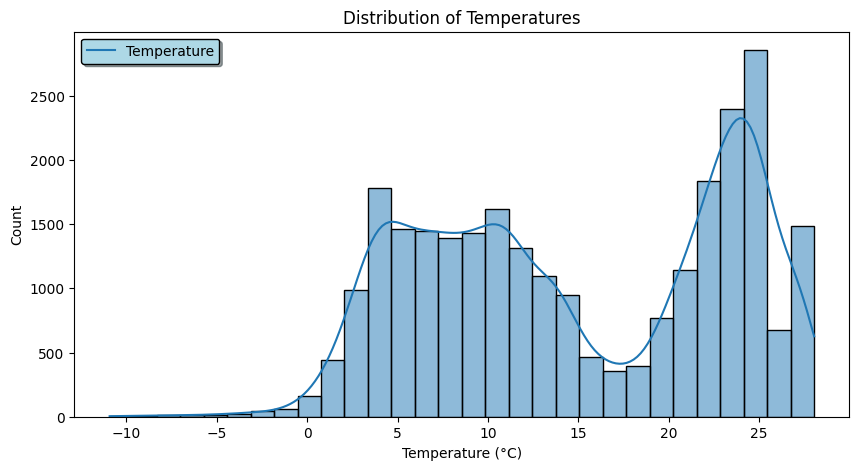

In [47]:
# analyse de la distribution des températures
plt.figure(figsize=(10, 5))

sns.histplot(df_final['T°(C°)'], kde=True, bins=30)

plt.title("Distribution of Temperatures")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.legend(
    labels=['Temperature'],
    loc='best',
    shadow=True,
    facecolor='lightblue',
    edgecolor='black'    
)
plt.show()

Text(0.5, 1.0, 'Distribution of Wind Speeds')

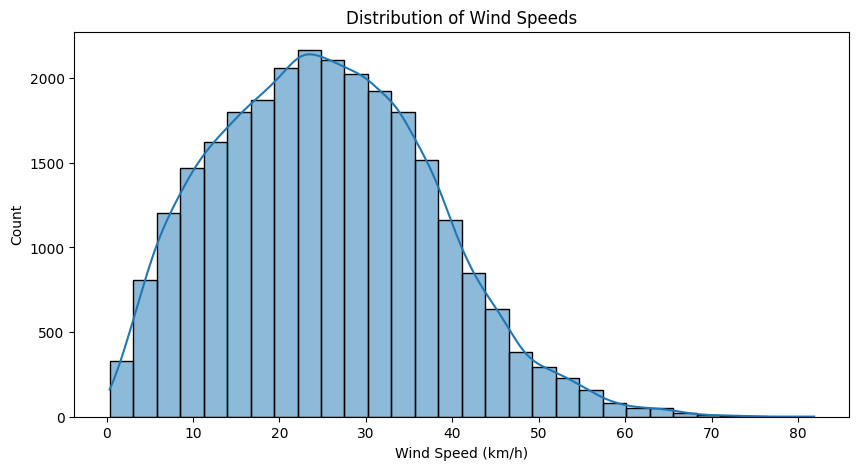

In [48]:
#analyse de la distribution de la vitesse du vent

plt.figure(figsize=(10, 5))

sns.histplot(df_final['Wind Speed (10m)'], kde=True, bins=30)
plt.xlabel("Wind Speed (km/h)")
plt.ylabel("Count")
plt.title("Distribution of Wind Speeds")

Analyses bivariées

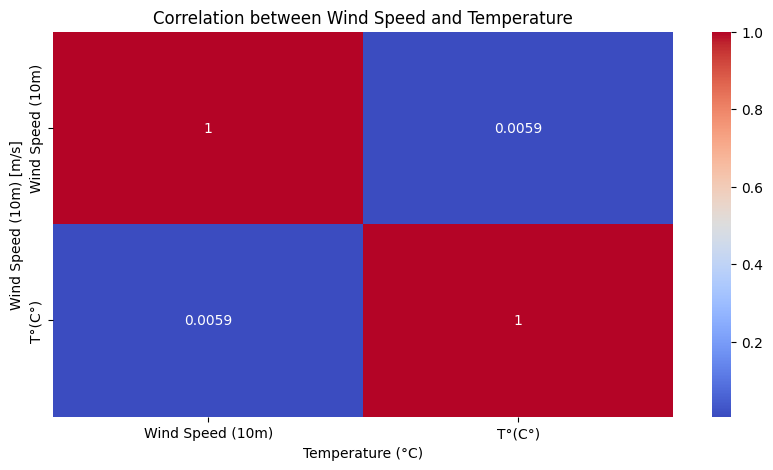

In [49]:
# Analyse de la relation entre la température et la vitesse du vent

corr_data = df_final[['Wind Speed (10m)', 'T°(C°)']].corr()

# Création de la heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar=True)

# Ajouter les labels aux axes
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind Speed (10m) [m/s]")
plt.title("Correlation between Wind Speed and Temperature")

# Afficher le graphique
plt.show()

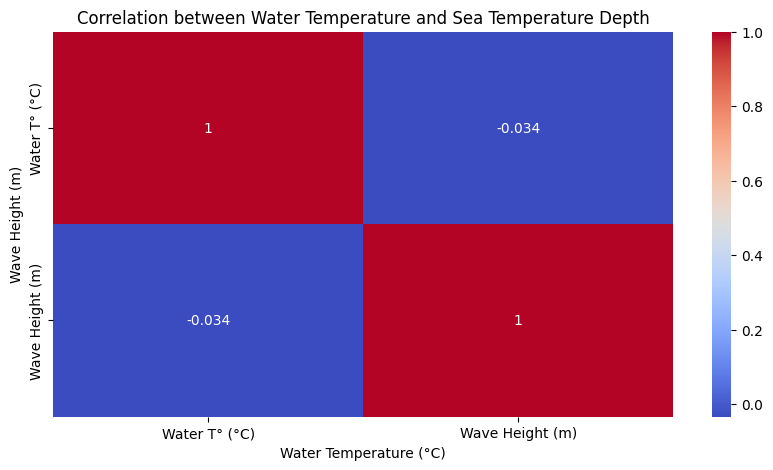

In [50]:
# Corrélation T° eau et hauteur des vagues
corr_data = df_final[['Water T° (°C)', 'Wave Height (m)']].corr()

# Création de la heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar=True)

# Ajouter les labels aux axes
plt.xlabel("Water Temperature (°C)")
plt.ylabel("Wave Height (m)")
plt.title("Correlation between Water Temperature and Sea Temperature Depth")

# Afficher le graphique
plt.show()

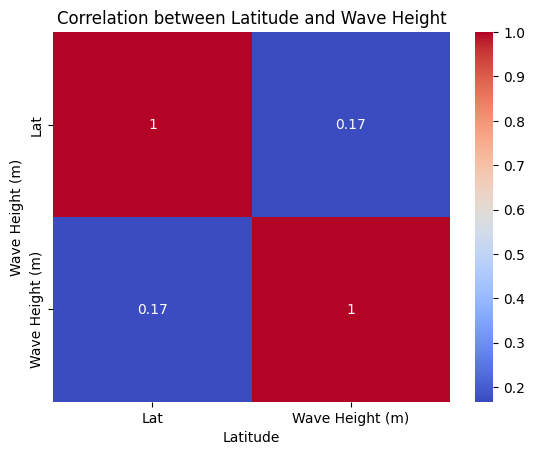

In [51]:
# correlation entre latitude et hauteur des vagues

corr_data = df_final[['Lat', 'Wave Height (m)']].corr()

# Création de la heatmap
plt.title("Correlation between Latitude and Wave Height")

# Création de la heatmap

sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar=True)

# Ajouter les labels aux axes

plt.xlabel("Latitude")
plt.ylabel("Wave Height (m)")

# Afficher le graphique
plt.show()

# 

# Analyses multivariées

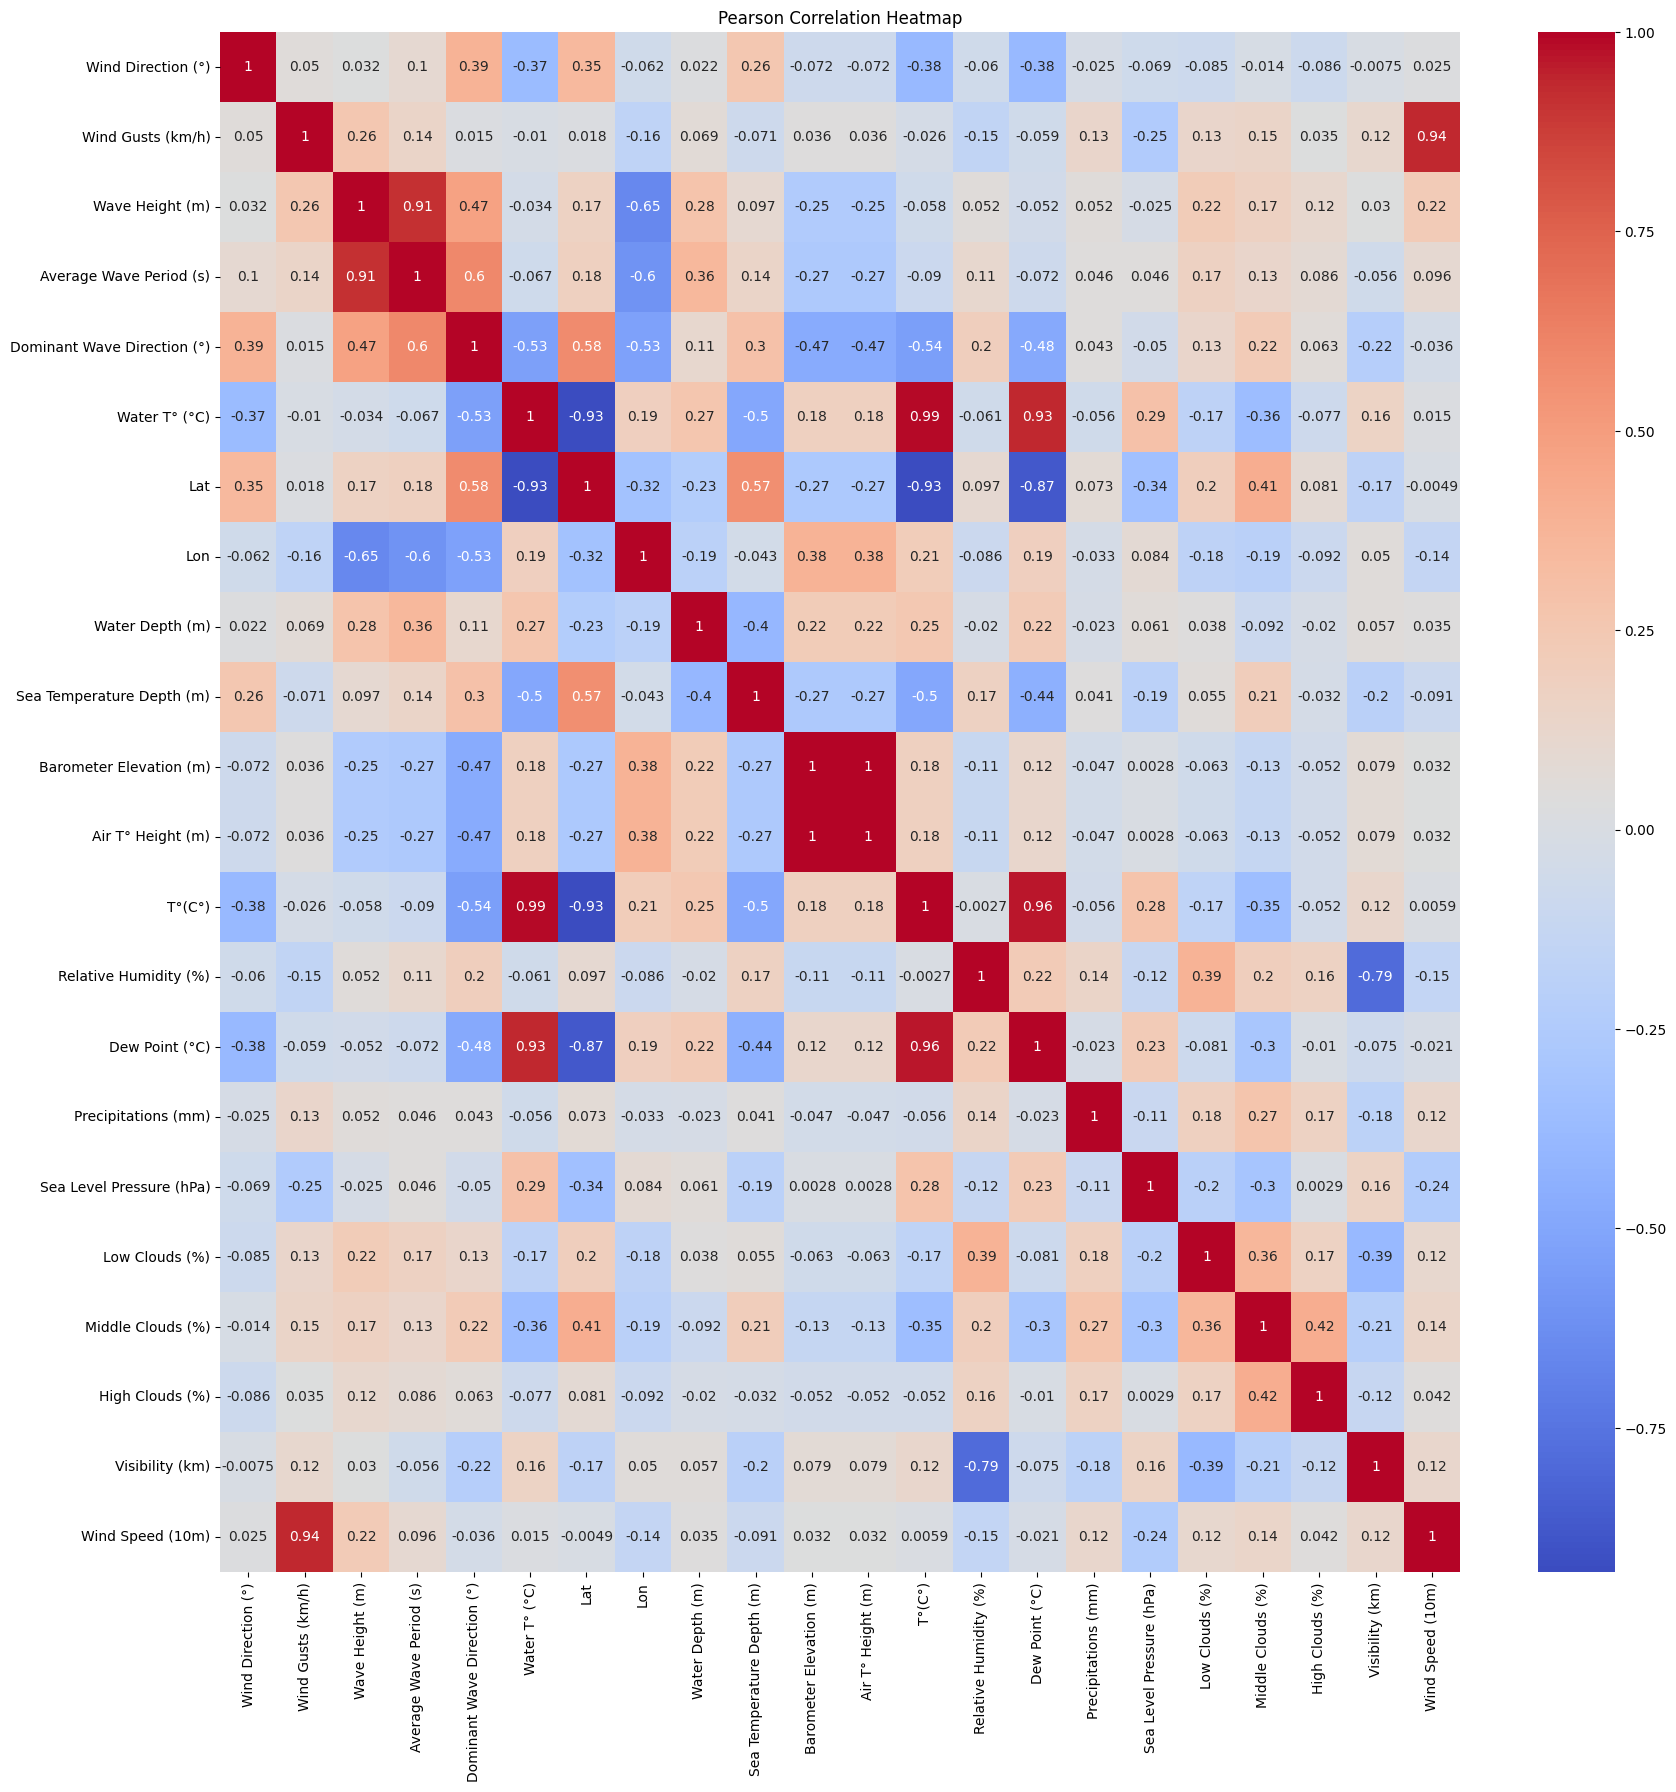

In [52]:
plt.figure(figsize=(20, 20))
df_numerical_columns = df_final.select_dtypes(include=[np.number]).columns
# KICK the year column

df_numerical_columns = df_numerical_columns[df_numerical_columns != 'Year']

corr_data = df_final[df_numerical_columns].corr(method='pearson')

sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar=True)

plt.title("Pearson Correlation Heatmap")
plt.show()


In [53]:
"""
'Wind Direction (°)', 'Wind Gusts (km/h)', 'Wave Height (m)',
'Average Wave Period (s)', 'Dominant Wave Direction (°)',
'Water T° (°C)', 'Lat', 'Lon', 'Water Depth (m)',
'Sea Temperature Depth (m)', 'Barometer Elevation (m)',
'Air T° Height (m)', 'T°(C°)', 'Relative Humidity (%)',
'Dew Point (°C)', 'Precipitations (mm)', 'Sea Level Pressure (hPa)',
'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
'Visibility (km)', 'Wind Speed (10m)', 'Year', 'Day', 'Hour', 'Month'


"""
"""
### 1. **Prédiction de la température de l'air (T°(C°))**
   - **Modèle recommandé** : **XGBoost** ou **LightGBM**
   - **Raison** : Ces modèles de **gradient boosting** 
   sont robustes face aux relations non linéaires et aux interactions complexes 
   entre les variables. Ils sont souvent plus performants que les modèles 
   linéaires lorsque les données sont complexes.

### 2. **Classification des conditions météorologiques (Ciel clair, nuageux, pluvieux, etc.)**
   - **Modèle recommandé** : **Random Forest** ou **XGBoost**
   - **Raison** : Les **Random Forest** et **XGBoost** sont puissants pour 
   gérer des jeux de données avec des relations non linéaires et beaucoup 
   de variables d'entrée. Ils offrent aussi une interprétabilité relative 
   via l'importance des variables.

### 3. **Prédiction de la hauteur des vagues (Wave Height)**
   - **Modèle recommandé** : **Random Forest** ou **Gradient Boosting Machines 
   (GBM)**
   - **Raison** : **Random Forest** est robuste aux relations non linéaires, 
   et **GBM** est très performant pour la régression quand il y a des relations 
   complexes à modéliser.

### 4. **Prédiction de la vitesse du vent (Wind Speed)**
   - **Modèle recommandé** : **XGBoost** ou **LSTM (Long Short-Term Memory)** 
   si les données sont temporelles
   - **Raison** : **XGBoost** est efficace pour des relations complexes et des 
   données avec beaucoup d'interactions. Si les données sont structurées dans 
   le temps (ex : séries chronologiques), un **LSTM** peut capturer les 
   dépendances temporelles.

### 5. **Prédiction des précipitations (Precipitations)**
   - **Modèle recommandé** : **XGBoost** ou **LightGBM**
   - **Raison** : **XGBoost** et **LightGBM** sont deux des meilleurs modèles 
   pour des prédictions de régression sur des données avec des relations non 
   linéaires. Ces modèles gèrent bien les variables complexes et sont très 
   performants.

### 6. **Détection de la tendance des vagues (en hausse ou en baisse)**
   - **Modèle recommandé** : **Random Forest** ou **SVM (Support Vector Machines)**
   - **Raison** : Pour un problème de classification binaire, 
   **Random Forest** peut bien capturer des tendances complexes et **SVM** 
   est efficace avec des données non linéaires.

### 7. **Estimation de la pression au niveau de la mer (Sea Level Pressure)**
   - **Modèle recommandé** : **Gradient Boosting Machines (GBM)** ou **Random 
   Forest**
   - **Raison** : **GBM** et **Random Forest** sont très bien adaptés à des 
   données avec des relations complexes et peuvent capturer des interactions 
   complexes entre les variables.

### 8. **Prédiction de la visibilité (Visibility)**
   - **Modèle recommandé** : **K-Nearest Neighbors (KNN)** ou **Random Forest**
   - **Raison** : **KNN** peut être un bon choix si les prédictions dépendent 
   beaucoup des valeurs locales (proximité des points de données). **Random Forest** 
   est plus robuste aux interactions complexes entre les variables.

### 9. **Estimation de la température de l'eau (Water T°) en fonction de la 
# profondeur (Water Depth)**
   - **Modèle recommandé** : **Random Forest** ou **SVR (Support Vector 
   Regression)**
   - **Raison** : **Random Forest** peut bien gérer des relations non 
   linéaires entre la température et la profondeur. **SVR** est également 
   efficace pour la régression sur des relations complexes non linéaires.

### 10. **Prévision de la direction du vent (Wind Direction)**
   - **Modèle recommandé** : **Circular Regression** (via Sine/Cosine 
   transformations) ou **Random Forest**
   - **Raison** : La direction du vent est une variable circulaire. 
   La **Circular Regression** permet de traiter des données circulaires, 
   en transformant la direction en variables **sinus et cosinus**. 
   Sinon, **Random Forest** peut être utilisé après transformation des données.

### Modèles supplémentaires pour des données avec relations non linéaires :
- **XGBoost**, **LightGBM** et **CatBoost** sont tous très performants pour 
modéliser des relations complexes avec des interactions non linéaires.
- **Random Forest** est également un excellent choix pour des données avec 
des interactions non linéaires, tout en étant facile à implémenter et robuste 
aux données bruitées.

### Résumé :
Ces modèles sont tous capables de capturer des relations **non linéaires** 
et **complexes** entre les variables, ce qui est particulièrement utile 
lorsque les corrélations de Pearson sont faibles. **XGBoost**, **Random 
Forest**, et **Gradient Boosting** sont particulièrement puissants pour 
ce type de données. Si tu travailles avec des séries temporelles, **LSTM** 
peut aussi être une excellente option.

"""

"\n### 1. **Prédiction de la température de l'air (T°(C°))**\n   - **Modèle recommandé** : **XGBoost** ou **LightGBM**\n   - **Raison** : Ces modèles de **gradient boosting** \n   sont robustes face aux relations non linéaires et aux interactions complexes \n   entre les variables. Ils sont souvent plus performants que les modèles \n   linéaires lorsque les données sont complexes.\n\n### 2. **Classification des conditions météorologiques (Ciel clair, nuageux, pluvieux, etc.)**\n   - **Modèle recommandé** : **Random Forest** ou **XGBoost**\n   - **Raison** : Les **Random Forest** et **XGBoost** sont puissants pour \n   gérer des jeux de données avec des relations non linéaires et beaucoup \n   de variables d'entrée. Ils offrent aussi une interprétabilité relative \n   via l'importance des variables.\n\n### 3. **Prédiction de la hauteur des vagues (Wave Height)**\n   - **Modèle recommandé** : **Random Forest** ou **Gradient Boosting Machines \n   (GBM)**\n   - **Raison** : **Random Fores

Random Forest pour la prédiction de la pression au niveau de la mer (Sea Level Pressure)

In [54]:
df_final.dtypes

ID Unique                              object
Wind Direction (°)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (°)           float64
Water T° (°C)                         float64
Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)             float64
Barometer Elevation (m)               float64
Air T° Height (m)                     float64
T°(C°)                                float64
Relative Humidity (%)                 float32
Dew Point (°C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Low Clouds (%)                    

In [55]:
display_row_values(df_final)

ID Unique        |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Datetime             |  Lat    |  Lon      |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  DayOfWeek  |  DayPeriod
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Building the DataFrames for the Data Warehouse Tables

In [57]:
# Connexion à MySQL
# Charger les informations de connexion MySQL
path_to_mysql_creds = r"c:\Credentials\mysql_creds.json"
with open(path_to_mysql_creds, 'r') as file:
    content = json.load(file)
    mysql_user = content["user"]
    password = content["password"]
    host = content["host"]
    port = content["port"]
    database = "oceanography_data_analysis"
    silver_table = "silver table"

# Connexion à MySQL avec SQLModel
engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{password}@{host}:{port}/{database}", isolation_level='AUTOCOMMIT')
Session = sessionmaker(bind=engine)
session = Session()

In [61]:
df_final.Datetime

0       2025-04-15 09:00:00
1       2025-04-15 08:00:00
2       2025-04-15 07:00:00
3       2025-04-15 06:00:00
4       2025-04-15 05:00:00
                ...        
26626   2025-03-01 04:00:00
26627   2025-03-01 03:00:00
26628   2025-03-01 02:00:00
26629   2025-03-01 01:00:00
26630   2025-03-01 00:00:00
Name: Datetime, Length: 26631, dtype: datetime64[ns]

In [64]:
import pandas as pd

# S'assurer que Datetime est bien en datetime64
df_final['Datetime'] = pd.to_datetime(df_final['Datetime'])

##################################### DimStation ##################################################################################################
df_station = df_final[['Station ID', 'Station Zone', 'Lat', 'Lon']].drop_duplicates()
df_station = df_station[['Station ID', 'Station Zone', 'Lat', 'Lon']]

print(f"\nNull count in df_station:\n{df_station.isnull().sum()}")

###################################### DimTime ##################################################################################################

df_time = df_final[['Year', 'Month', 'DayOfWeek', 'DayPeriod', 'Datetime']].drop_duplicates()

# Création de Date ID à partir de Datetime
df_time['Date ID'] = df_time['Datetime'].apply(lambda x: int(x.strftime('%Y%m%d%H')))

# Extraction de Day et Hour
df_time['Day'] = df_time['Datetime'].dt.day
df_time['Hour'] = df_time['Datetime'].dt.hour

# Réorganisation
df_time = df_time[['Date ID', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'DayPeriod']]

print(f"\nNull count in df_time:\n{df_time.isnull().sum()}")

########################################## Facts Meteo #########################################################################

df_facts_meteo = df_final[[
    'ID Unique', 'T°(C°)', 'Relative Humidity (%)', 'Dew Point (°C)',
    'Precipitations (mm)', 'Sea Level Pressure (hPa)', 'Low Clouds (%)',
    'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)', 'Wind Speed (10m)',
    'Wind Direction (°)', 'Wind Gusts (km/h)', 'Barometer Elevation (m)',
    'Air T° Height (m)', 'Station ID', 'Datetime'
]].copy()

# Date ID à partir de Datetime
df_facts_meteo['Date ID'] = df_facts_meteo['Datetime'].apply(lambda x: int(x.strftime('%Y%m%d%H')))

# Organisation des colonnes
df_facts_meteo = df_facts_meteo[[
    'ID Unique', 'T°(C°)', 'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
    'Sea Level Pressure (hPa)', 'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
    'Visibility (km)', 'Wind Speed (10m)', 'Wind Direction (°)', 'Wind Gusts (km/h)',
    'Barometer Elevation (m)', 'Air T° Height (m)', 'Date ID', 'Station ID'
]]

print(f"\nNull count in df_facts_meteo:\n{df_facts_meteo.isnull().sum()}")

########################################## Facts Ocean #########################################################################

df_facts_ocean = df_final[[
    'ID Unique', 'Wave Height (m)', 'Average Wave Period (s)', 'Dominant Wave Direction (°)',
    'Water T° (°C)', 'Water Depth (m)', 'Sea Temperature Depth (m)', 'Station ID', 'Datetime'
]].copy()

# Date ID à partir de Datetime
df_facts_ocean['Date ID'] = df_facts_ocean['Datetime'].apply(lambda x: int(x.strftime('%Y%m%d%H')))

# Organisation des colonnes
df_facts_ocean = df_facts_ocean[[
    'ID Unique', 'Wave Height (m)', 'Average Wave Period (s)', 'Dominant Wave Direction (°)',
    'Water T° (°C)', 'Water Depth (m)', 'Sea Temperature Depth (m)', 'Date ID', 'Station ID'
]]

print(f"\nNull count in df_facts_ocean:\n{df_facts_ocean.isnull().sum()}")



Null count in df_station:
Station ID      0
Station Zone    0
Lat             0
Lon             0
dtype: int64

Null count in df_time:
Date ID      0
Year         0
Month        0
Day          0
Hour         0
DayOfWeek    0
DayPeriod    0
dtype: int64

Null count in df_facts_meteo:
ID Unique                   0
T°(C°)                      0
Relative Humidity (%)       0
Dew Point (°C)              0
Precipitations (mm)         0
Sea Level Pressure (hPa)    0
Low Clouds (%)              0
Middle Clouds (%)           0
High Clouds (%)             0
Visibility (km)             0
Wind Speed (10m)            0
Wind Direction (°)          0
Wind Gusts (km/h)           0
Barometer Elevation (m)     0
Air T° Height (m)           0
Date ID                     0
Station ID                  0
dtype: int64

Null count in df_facts_ocean:
ID Unique                      0
Wave Height (m)                0
Average Wave Period (s)        0
Dominant Wave Direction (°)    0
Water T° (°C)                

In [ ]:
# Vérifier les doublons
print(f"Doublons dans df_station : {df_station.duplicated().sum()}")
print(f"Doublons dans df_time : {df_time.duplicated().sum()}")
print(f"Doublons dans df_facts_meteo : {df_facts_meteo.duplicated().sum()}")
print(f"Doublons dans df_facts_ocean : {df_facts_ocean.duplicated().sum()}")


# Vérifier si les clés étrangères existent dans les dimensions
print(f"Stations ID dans df_facts_meteo qui ne sont pas dans df_station : {df_facts_meteo[~df_facts_meteo['Station ID'].isin(df_station['Station ID'])].shape[0]}")
print(f"Date ID dans df_facts_meteo qui ne sont pas dans df_time : {df_facts_meteo[~df_facts_meteo['Date ID'].isin(df_time['Date ID'])].shape[0]}")

print(f"Stations ID dans df_facts_ocean qui ne sont pas dans df_station : {df_facts_ocean[~df_facts_ocean['Station ID'].isin(df_station['Station ID'])].shape[0]}")
print(f"Date ID dans df_facts_ocean qui ne sont pas dans df_time : {df_facts_ocean[~df_facts_ocean['Date ID'].isin(df_time['Date ID'])].shape[0]}")

# Vérification des valeurs de base
print(f"\nDescription des données de df_station : \n{df_station.describe()}")
print(f"\nDescription des données de df_time : \n{df_time.describe()}")
print(f"\nDescription des données de df_facts_meteo : \n{df_facts_meteo.describe()}")
print(f"\nDescription des données de df_facts_ocean : \n{df_facts_ocean.describe()}")

Doublons dans df_station : 0
Doublons dans df_time : 0
Doublons dans df_facts_meteo : 0
Doublons dans df_facts_ocean : 0
Stations ID dans df_facts_meteo qui ne sont pas dans df_station : 0
Date ID dans df_facts_meteo qui ne sont pas dans df_time : 0
Stations ID dans df_facts_ocean qui ne sont pas dans df_station : 0
Date ID dans df_facts_ocean qui ne sont pas dans df_time : 0

Description des données de df_station : 
             Lat         Lon
count  24.000000   24.000000
mean   34.766250 -110.377917
std    12.237361   35.116833
min    14.510000 -172.150000
25%    25.567500 -136.375000
50%    33.130000 -118.550000
75%    42.260000  -79.440000
max    56.610000  -58.630000

Description des données de df_time : 
            Date ID    Year        Month          Day         Hour
count  1.097000e+03  1097.0  1097.000000  1097.000000  1097.000000
mean   2.025033e+09  2025.0     3.146764    14.544211    11.445761
std    4.976825e+03     0.0     0.548198     9.396192     6.912053
min    2.02

In [ ]:
# check unique values
print(f"{df_station.shape[0]}\n\n{df_station.nunique()}")
display_row_values(df_station)

24

Station ID      24
Station Zone    24
Lat             24
Lon             24
dtype: int64
Station ID  |  Station Zone                              |  Lat    |  Lon    
--------------------------------------------------------------------------
41008       |  grays reef                                |  31.4   |  -80.87 
41044       |  ne st martin                              |  21.58  |  -58.63 
41049       |  south bermuda                             |  27.5   |  -62.27 
42001       |  mid gulf                                  |  25.93  |  -89.66 
42002       |  west gulf                                 |  25.95  |  -93.78 
42036       |  west tampa                                |  28.5   |  -84.5  
42056       |  yucatan basin                             |  19.82  |  -84.98 
42058       |  central caribbean                         |  14.51  |  -75.15 
44007       |  portland                                  |  43.52  |  -70.14 
44020       |  nantucket sound                      

In [ ]:
# try:
#     create_table_in_mysql(df=df_station, engine=engine, table_name='dim_station')
#     insert_new_rows(df=df_station, engine=engine, table='dim_station', ref_column='Station ID')
# except Exception as e:
#     print(e)

In [ ]:
print(f"{df_time.shape[0]}\n\n{df_time.nunique()}")
display_row_values(df_time)

1097

Date ID      1097
Year            1
Month           3
Day            31
Hour           24
DayOfWeek       7
DayPeriod       4
dtype: int64
Date ID     |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
--------------------------------------------------------------------
2025041116  |  2025  |  4      |  11   |  16    |  Friday     |  Afternoon
2025041115  |  2025  |  4      |  11   |  15    |  Friday     |  Afternoon
2025041114  |  2025  |  4      |  11   |  14    |  Friday     |  Afternoon
2025041113  |  2025  |  4      |  11   |  13    |  Friday     |  Afternoon
2025041112  |  2025  |  4      |  11   |  12    |  Friday     |  Afternoon
2025041111  |  2025  |  4      |  11   |  11    |  Friday     |  Morning  
2025041110  |  2025  |  4      |  11   |  10    |  Friday     |  Morning  
2025041109  |  2025  |  4      |  11   |  9     |  Friday     |  Morning  
2025041108  |  2025  |  4      |  11   |  8     |  Friday     |  Morning  
2025041107  |  2025  |  4      |  11

In [ ]:
def insert_new_rows(df: pd.DataFrame, engine, table: str, ref_column: str):
    """
    Insère les nouvelles lignes dans la table MySQL après avoir vérifié si les IDs uniques existent déjà.

    Args:
    - df (pd.DataFrame): Le DataFrame contenant les nouvelles données.
    - engine (SQLAlchemy Engine): L'engine SQLAlchemy pour se connecter à la base de données.
    - table (str): Le nom de la table dans laquelle insérer les données.
    - ref_column (str): Le nom de la colonne à utiliser comme référence (ID unique).
    """
    try:
        print("🔍 Connexion à la base de données en cours...")

        with engine.connect() as connection:
            # Vérifier si la table est vide
            print("🧮 Vérification si la table est vide...")
            check_empty_sql = f"SELECT COUNT(*) FROM `{table}`"
            result = connection.execute(text(check_empty_sql))
            row_count = result.fetchone()[0]

            if row_count == 0:
                # La table est vide, insérer toutes les données avec compteur
                print("⚡ La table est vide. Insertion de toutes les données avec suivi...")
                total = len(df)
                inserted = 0
                for _, row in df.iterrows():
                    row_df = pd.DataFrame([row])
                    row_df.to_sql(table, con=engine, if_exists='append', index=False)
                    inserted += 1
                    sys.stdout.write(f"\r⏳ Insertion en cours : {inserted}/{total}")
                    sys.stdout.flush()
                print("\n✅ Toutes les lignes ont été insérées dans la table.")
            else:
                # Sinon, récupérer les IDs existants dans la table
                print(f"🔎 Récupération des {ref_column} existants dans la table...")
                check_existing_ids_sql = f"SELECT `{ref_column}` FROM `{table}`"
                result = connection.execute(text(check_existing_ids_sql))
                existing_ids = {row[0] for row in result.fetchall()}
                print(f"🧑‍💻 {len(existing_ids)} {ref_column} existants ont été trouvés dans la table.")

                # Filtrage des lignes du DataFrame
                print("🔄 Filtrage des nouvelles lignes à insérer...")
                new_rows_df = df[~df[ref_column].isin(existing_ids)]

                if not new_rows_df.empty:
                    total = len(new_rows_df)
                    print(f"🚀 Insertion de {total} nouvelles lignes...")
                    inserted = 0
                    for _, row in new_rows_df.iterrows():
                        row_df = pd.DataFrame([row])
                        row_df.to_sql(table, con=engine, if_exists='append', index=False)
                        inserted += 1
                        sys.stdout.write(f"\r⏳ Insertion en cours : {inserted}/{total}")
                        sys.stdout.flush()
                    print("\n✅ Insertion terminée avec succès.")
                else:
                    print(f"⚠️ Aucune nouvelle ligne à insérer, tous les {ref_column} sont déjà présents.")
    except Exception as e:
        print(f"❌ Erreur lors de l'insertion dans la table '{table}': {e}")


In [ ]:
# try:
#     create_table_in_mysql(df=df_time, engine=engine, table_name='dim_time')
#     insert_new_rows(df=df_time, engine=engine, table='dim_time', ref_column='Date ID')
# except Exception as e:
#     print(e)

In [ ]:
print(f"{df_facts_meteo.shape[0]}\n\n{df_facts_meteo.nunique()}")
display_row_values(df_facts_meteo)

25519

ID Unique                   25519
T°(C°)                       1810
Relative Humidity (%)          72
Dew Point (°C)                415
Precipitations (mm)            69
Sea Level Pressure (hPa)      581
Low Clouds (%)                101
Middle Clouds (%)             101
High Clouds (%)               101
Visibility (km)              1264
Wind Speed (10m)             3648
Wind Direction (°)             36
Wind Gusts (km/h)              28
Barometer Elevation (m)         3
Air T° Height (m)               3
Date ID                      1097
Station ID                     24
dtype: int64
ID Unique        |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  Date ID     |  Station ID
--------------------------------------------------

In [ ]:
try:
    create_table_in_mysql(df=df_facts_meteo, engine=engine, table_name='facts_meteo')
    insert_new_rows(df=df_facts_meteo, engine=engine, table='facts_meteo', ref_column='ID Unique')
except Exception as e:
    print(e)

In [ ]:
print(f"{df_facts_ocean.shape[0]}\n\n{df_facts_ocean.nunique()}")
display_row_values(df_facts_ocean)

25519

ID Unique                      25519
Wave Height (m)                   45
Average Wave Period (s)           65
Dominant Wave Direction (°)      150
Water T° (°C)                    278
Water Depth (m)                   24
Sea Temperature Depth (m)          3
Date ID                         1097
Station ID                        24
dtype: int64
ID Unique        |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Date ID     |  Station ID
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
410082025041116  |  0.9              |  4.8                      |  110.0                        |  19.7           |  16.0             |  2.0                        |  2025041116  |  41008     
410082025041115  |  0.9              |  4.8                      |  110.0

In [ ]:
try:
    create_table_in_mysql(df=df_facts_ocean, engine=engine, table_name='facts_ocean')
    insert_new_rows(df=df_facts_ocean, engine=engine, table='facts_ocean', ref_column='ID Unique')
except Exception as e:
    print(e)